# Exploring Ebay Car Sales Data

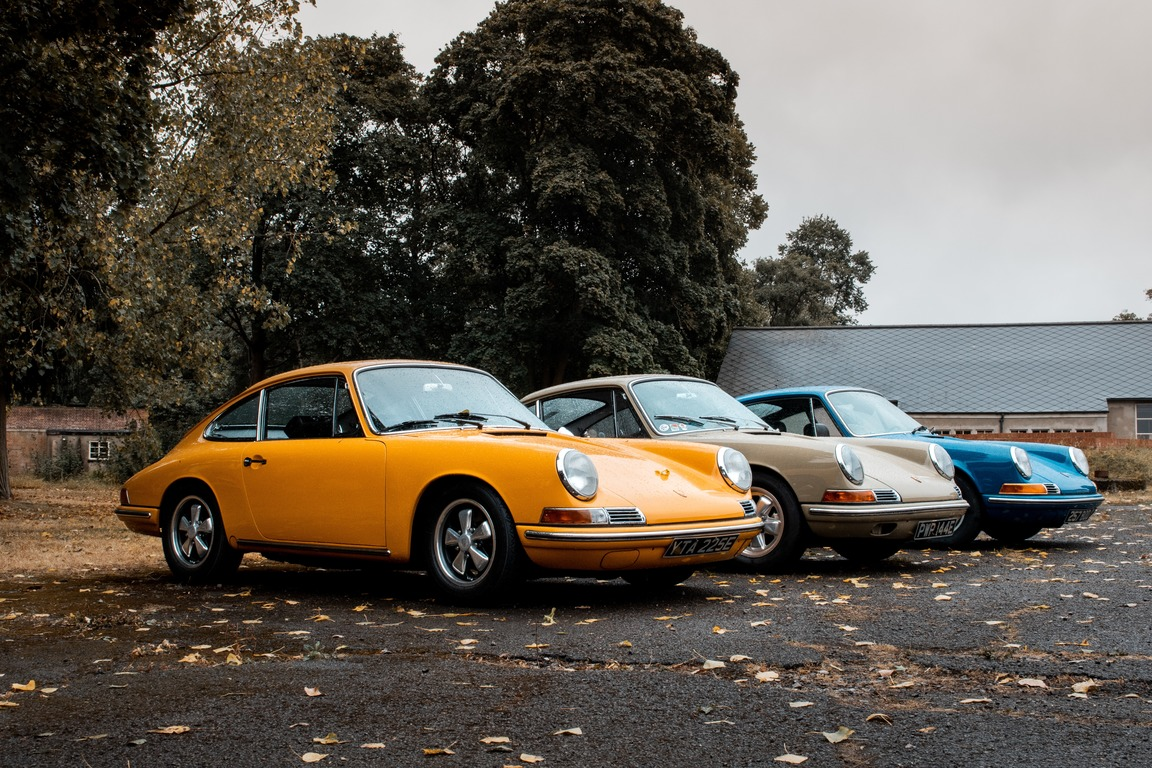

The aim of this project is to clean a dataset of used cars from eBay Kleinanzeigen (a classified section of the German eBay website) and analyze the included used car listings. 

The dataset was originally scraped from [here](https://data.world/data-society/used-cars-data) and uploaded to Kaggle. In this project, we're using its reduced version: 50,000 data points sampled from the full dataset. The original Kaggle dataset is not available anymore.
### Summary of Results
- The prices range from 0 to 350,000 dollars, with an average of 5,813.
- 65% of all cars have driven 150,000 km.
- The oldest car has the registration year 1927, the latest – 2016.
- The most popular brand is Volkswagen (21%), the most common brand/model combination – Volkswagen Golf.
- The highest average price by mileage category is related to the cars with low values of mileage (20,000-30,000 km). For higher values, average prices decrease proportionally.
- At least 10% of all the cars have unrepaired damages. Damaged cars cost, on average, 3.5 times less than non-damaged.

## Data Downloading and Understanding

In [1]:
import pandas as pd
import numpy as np
import operator
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)

autos = pd.read_csv('autos.csv', encoding='Latin-1')
print(f'\033[1mNumber of rows:\033[0m {autos.shape[0]:,}\n'
      f'\033[1mNumber of columns:\033[0m {autos.shape[1]}\n'
      f'\033[1m\nColumn names:\033[0m\n'
      f'{list(autos.columns)}\n\n\n'
      f'\033[1mData types:\033[0m\n\n{autos.dtypes}\n\n\n'
      f'\033[1mMissing values by column, %:\033[0m\n\n'
      f'{round((autos.isnull().sum()*100/len(autos))).convert_dtypes()}')

Number of rows: 50,000
Number of columns: 20

Column names:
['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model', 'odometer', 'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen']


Data types:

dateCrawled            object
name                   object
seller                 object
offerType              object
price                  object
abtest                 object
vehicleType            object
yearOfRegistration      int64
gearbox                object
powerPS                 int64
model                  object
odometer               object
monthOfRegistration     int64
fuelType               object
brand                  object
notRepairedDamage      object
dateCreated            object
nrOfPictures            int64
postalCode              int64
lastSeen               object
dtype: object


Missing values by column, %:

dateCrawled

Some observations can be made here:
- A few columns have null values, up to 20% for the `notRepairedDamage` column. 
- The majority of columns are string (object), including `price` and `odometer`, which will probably have to be fixed.
- The column names use JavaScript's preferred camel case instead of Python's preferred snake case, which means we can't just replace spaces with underscores. Given that some of the names are long and compound, it makes it more difficult to catch their meaning.

Let's investigate the first 10 rows of the dataset:

In [2]:
autos.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,odometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-26 17:47:46,Peugeot_807_160_NAVTECH_ON_BOARD,privat,Angebot,"$5,000",control,bus,2004,manuell,158,andere,"150,000km",3,lpg,peugeot,nein,2016-03-26 00:00:00,0,79588,2016-04-06 06:45:54
1,2016-04-04 13:38:56,BMW_740i_4_4_Liter_HAMANN_UMBAU_Mega_Optik,privat,Angebot,"$8,500",control,limousine,1997,automatik,286,7er,"150,000km",6,benzin,bmw,nein,2016-04-04 00:00:00,0,71034,2016-04-06 14:45:08
2,2016-03-26 18:57:24,Volkswagen_Golf_1.6_United,privat,Angebot,"$8,990",test,limousine,2009,manuell,102,golf,"70,000km",7,benzin,volkswagen,nein,2016-03-26 00:00:00,0,35394,2016-04-06 20:15:37
3,2016-03-12 16:58:10,Smart_smart_fortwo_coupe_softouch/F1/Klima/Pan...,privat,Angebot,"$4,350",control,kleinwagen,2007,automatik,71,fortwo,"70,000km",6,benzin,smart,nein,2016-03-12 00:00:00,0,33729,2016-03-15 03:16:28
4,2016-04-01 14:38:50,Ford_Focus_1_6_Benzin_TÜV_neu_ist_sehr_gepfleg...,privat,Angebot,"$1,350",test,kombi,2003,manuell,0,focus,"150,000km",7,benzin,ford,nein,2016-04-01 00:00:00,0,39218,2016-04-01 14:38:50


- In some columns (`seller`, `offerType`, `gearbox`, `notRepairedDamage`), values are written in German. 
- The columns `price` and `odometer` show the units for each value. 
- The columns `seller`, `offerType`, `notRepairedDamage`, and `nrOfPictures` seem to have a dominant value each (with `notRepairedDamage` also having a lot of null values) and probably will not represent much interest for further data analysis.

## Cleaning Column Names
Let's convert the column names from camel case to snake case and reword some of them based on the data dictionary to be more descriptive:

In [3]:
def camel_to_snake(str): 
    res = [str[0].lower()] 
    for c in str[1:]: 
        if c in ('ABCDEFGHIJKLMNOPQRSTUVWXYZ'): 
            res.append('_') 
            res.append(c.lower()) 
        else: 
            res.append(c)
    return ''.join(res) 

# Converting the column names
autos.columns = [camel_to_snake(column) for column in autos.columns]
autos.columns

Index(['date_crawled', 'name', 'seller', 'offer_type', 'price', 'abtest',
       'vehicle_type', 'year_of_registration', 'gearbox', 'power_p_s', 'model',
       'odometer', 'month_of_registration', 'fuel_type', 'brand',
       'not_repaired_damage', 'date_created', 'nr_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

In this way, the column names look more Python-style. However, for making them more descriptive, it's worth doing some further renaming:

In [4]:
autos.rename({'abtest': 'ab_test', 'year_of_registration': 'registration_year', 
              'power_p_s': 'power_ps', 'month_of_registration': 'registration_month',
              'not_repaired_damage': 'unrepaired_damage', 'date_created': 'ad_created', 
              'nr_of_pictures': 'number_pictures'}, axis=1, inplace=True)

autos.columns

Index(['date_crawled', 'name', 'seller', 'offer_type', 'price', 'ab_test',
       'vehicle_type', 'registration_year', 'gearbox', 'power_ps', 'model',
       'odometer', 'registration_month', 'fuel_type', 'brand',
       'unrepaired_damage', 'ad_created', 'number_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

Now all the column names are in line with Python's naming convention and represent a clear and informative description of their contents.
## Initial Data Exploration and Cleaning
Let's do some basic data exploration to determine what other cleaning tasks need to be done:

In [5]:
autos.describe(include='all').round().convert_dtypes()

,date_crawled,name,seller,offer_type,price,ab_test,vehicle_type,registration_year,gearbox,power_ps,model,odometer,registration_month,fuel_type,brand,unrepaired_damage,ad_created,number_pictures,postal_code,last_seen
count,50000,50000,50000,50000,50000,50000,44905,50000,47320,50000,47242,50000,50000,45518,50000,40171,50000,50000,50000,50000
unique,48213,38754,2,2,2357,2,8,<NA>,2,<NA>,245,13,<NA>,7,40,2,76,<NA>,<NA>,39481
top,2016-03-14 20:50:02,Ford_Fiesta,privat,Angebot,$0,test,limousine,<NA>,manuell,<NA>,golf,"150,000km",<NA>,benzin,volkswagen,nein,2016-04-03 00:00:00,<NA>,<NA>,2016-04-07 06:17:27
freq,3,78,49999,49999,1421,25756,12859,<NA>,36993,<NA>,4024,32424,<NA>,30107,10687,35232,1946,<NA>,<NA>,8
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005,NaN,116,NaN,NaN,6,NaN,NaN,NaN,NaN,0,50814,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106,NaN,209,NaN,NaN,4,NaN,NaN,NaN,NaN,0,25780,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,NaN,0,NaN,NaN,0,NaN,NaN,NaN,NaN,0,1067,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999,NaN,70,NaN,NaN,3,NaN,NaN,NaN,NaN,0,30451,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,105,NaN,NaN,6,NaN,NaN,NaN,NaN,0,49577,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008,NaN,150,NaN,NaN,9,NaN,NaN,NaN,NaN,0,71540,NaN


From these statistics, we can draw many insights:

- The columns `seller`, `offer_type`, and `number_pictures` have practically one value each, which is exactly what we supposed earlier. These columns have to be dropped.
- The `price` and `odometer` columns are numeric data stored as text (again, as we noticed earlier). They have to be cleaned and converted to a numeric data type.
- The columns `registration_year`, `registration_month`, and `power_ps` have obvious outliers. This has to be fixed.
- One curious observation about the `price` column: 1,421 out of 50,000 entries have a price of 0$, meaning that around 3% of all the cars are actually free of charge.
- More than 9.5% of all cars have unrepaired damages.

Let's drop the non-informative columns `seller`, `offer_type`, and `number_pictures`:

In [6]:
autos.drop(['seller', 'offer_type', 'number_pictures'], axis=1, inplace=True)

There is one more interesting column to take a look at: `fuel_type`:

In [7]:
round(autos['fuel_type'].value_counts()*100/len(autos), 2)

benzin     60.21
diesel     29.13
lpg         1.38
cng         0.15
hybrid      0.07
andere      0.04
elektro     0.04
Name: fuel_type, dtype: float64

We see that benzine is the most common fuel type followed by diesel, while the other types, altogether less than 2%, are liquified/compressed natural gas, hybrid, electro, and "other" ("andere" in German).

Next, we're going to identify categorical data that uses German words, translate them, and map to their English counterparts. After deleting the non-informative columns, we have the following ones containg German words: `gearbox`, `fuel_type`, and `unrepaired_damage`. Let's investigate their vocabulary:

In [8]:
print(f"'gearbox':           {autos['gearbox'].unique()}\n"
      f"'fuel_type':         {autos['fuel_type'].unique()}\n"
      f"'unrepaired_damage': {autos['unrepaired_damage'].unique()}")

'gearbox':           ['manuell' 'automatik' nan]
'fuel_type':         ['lpg' 'benzin' 'diesel' nan 'cng' 'hybrid' 'elektro' 'andere']
'unrepaired_damage': ['nein' nan 'ja']


Let's create a unique "German dictionary" for these words and map them into English meanings:

In [9]:
german_dict = {'manuell': 'manual',
               'automatik': 'automatic',
               'benzin': 'benzine',
               'elektro': 'electro',
               'andere': 'other',
               'nein': 'no',
               'ja': 'yes',
    
               # Next words remain the same, but have to be mapped to avoid NaN 
               'lpg': 'lpg',
               'diesel': 'diesel',
               'cng': 'cng',
               'hybrid': 'hybrid'}

# Mapping German words in English
for column in ['gearbox', 'fuel_type', 'unrepaired_damage']:
    autos[column] = autos[column].map(german_dict)

# Checking updated unique values
print(f"'gearbox':           {autos['gearbox'].unique()}\n"
      f"'fuel_type':         {autos['fuel_type'].unique()}\n"
      f"'unrepaired_damage': {autos['unrepaired_damage'].unique()}")

'gearbox':           ['manual' 'automatic' nan]
'fuel_type':         ['lpg' 'benzine' 'diesel' nan 'cng' 'hybrid' 'electro' 'other']
'unrepaired_damage': ['no' nan 'yes']


## Exploring the `Odometer` and `Price` Columns
Let's clean the `price` and `odometer` columns:

In [10]:
# Removing non-numeric characters and converting the columns to a numeric data type
autos['price'] = autos['price'].str.replace('$','').str.replace(',','').astype(int)
autos['odometer'] = autos['odometer'].str.replace('km','').str.replace(',','').astype(int)

# Renaming columns
autos.rename({'price': 'price_dollars', 'odometer': 'odometer_km'}, axis=1, inplace=True)
autos.head()

,date_crawled,name,price_dollars,ab_test,vehicle_type,registration_year,gearbox,power_ps,model,odometer_km,registration_month,fuel_type,brand,unrepaired_damage,ad_created,postal_code,last_seen
0,2016-03-26 17:47:46,Peugeot_807_160_NAVTECH_ON_BOARD,5000,control,bus,2004,manual,158,andere,150000,3,lpg,peugeot,no,2016-03-26 00:00:00,79588,2016-04-06 06:45:54
1,2016-04-04 13:38:56,BMW_740i_4_4_Liter_HAMANN_UMBAU_Mega_Optik,8500,control,limousine,1997,automatic,286,7er,150000,6,benzine,bmw,no,2016-04-04 00:00:00,71034,2016-04-06 14:45:08
2,2016-03-26 18:57:24,Volkswagen_Golf_1.6_United,8990,test,limousine,2009,manual,102,golf,70000,7,benzine,volkswagen,no,2016-03-26 00:00:00,35394,2016-04-06 20:15:37
3,2016-03-12 16:58:10,Smart_smart_fortwo_coupe_softouch/F1/Klima/Pan...,4350,control,kleinwagen,2007,automatic,71,fortwo,70000,6,benzine,smart,no,2016-03-12 00:00:00,33729,2016-03-15 03:16:28
4,2016-04-01 14:38:50,Ford_Focus_1_6_Benzin_TÜV_neu_ist_sehr_gepfleg...,1350,test,kombi,2003,manual,0,focus,150000,7,benzine,ford,no,2016-04-01 00:00:00,39218,2016-04-01 14:38:50


Now the columns `price_dollars` and `odometer_km` are in the right format to be analyzed.

Let's look at the statistics of prices:

In [11]:
autos['price_dollars'].describe().round().convert_dtypes()

count       50000
mean         9840
std        481104
min             0
25%          1100
50%          2950
75%          7200
max      99999999
Name: price_dollars, dtype: Int64

There is an outlier: the maximum value is 4 orders bigger than the value of the third quartile (75%), and in general, it doesn't look like a realistic price for a used car on sale. As for the minimum value equals 0, it looks ok and represents the cars offered free of charge. 

We'll investigate in more detail the maximum value now:

In [12]:
# Finding the 15 biggest prices in descending order
fifteen_biggest_prices = autos['price_dollars'].value_counts().sort_index(ascending=False).head(15)
fifteen_biggest_prices

99999999    1
27322222    1
12345678    3
11111111    2
10000000    1
3890000     1
1300000     1
1234566     1
999999      2
999990      1
350000      1
345000      1
299000      1
295000      1
265000      1
Name: price_dollars, dtype: int64

It seems that not only the maximum value but all the prices higher than 350,000 dollars look strange, probably some of them were intended to represent undefined values. The values 27,322,222, 3,890,000, and 1,300,000 dollars look theoretically plausible, but in any case, they are evident outliers with respect to all the other values. We have to remove them from the dataset:

In [13]:
# Removing the outliers
autos = autos[autos['price_dollars']<=350000]
autos['price_dollars'].describe().round().convert_dtypes()

count     49986
mean       5722
std        8984
min           0
25%        1100
50%        2950
75%        7200
max      350000
Name: price_dollars, dtype: Int64

Now the values of the `price_dollars` column are cleaned and meaningful, with the maximum price of 350,000 dollars, the average of 5,813 dollars, and the minimum free of charge.

Let's conduct a similar analysis for the `odometer_km` column:

In [14]:
print(f"{autos['odometer_km'].describe().round().convert_dtypes()}\n\n"
      f"\033[1mOdometer values:\033[0m\n{sorted(autos['odometer_km'].unique())}\n\n"
      f"\033[1mThe most frequent odometer values, in % of cars:\033[0m\n\n{round(autos['odometer_km'].value_counts()*100/len(autos)).convert_dtypes().head()}"
     )

count     49986
mean     125737
std       40038
min        5000
25%      125000
50%      150000
75%      150000
max      150000
Name: odometer_km, dtype: Int64

Odometer values:
[5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 125000, 150000]

The most frequent odometer values, in % of cars:

150000    65
125000    10
100000     4
90000      4
80000      3
Name: odometer_km, dtype: Int64


In this column, we don't have any outliers. The values range from 5,000 to 150,000 km, with an average of 125,567 km. These statistics are heavily influenced by the frequency of the maximum value: 65% of cars in our dataset have driven 150,000 km.
## Exploring the Date Columns
Let's now understand the date range the data covers. There are 5 columns representing date values. Some of these columns were created by the crawler (`date_crawled` and `last_seen`), the others came from the website itself (`ad_created`, `registration_month`, and `registration_year`).

The columns `registration_month` and `registration_year` are numeric. Let's take a look at the other three:

In [15]:
autos[['date_crawled','ad_created','last_seen']].head()

,date_crawled,ad_created,last_seen
0,2016-03-26 17:47:46,2016-03-26 00:00:00,2016-04-06 06:45:54
1,2016-04-04 13:38:56,2016-04-04 00:00:00,2016-04-06 14:45:08
2,2016-03-26 18:57:24,2016-03-26 00:00:00,2016-04-06 20:15:37
3,2016-03-12 16:58:10,2016-03-12 00:00:00,2016-03-15 03:16:28
4,2016-04-01 14:38:50,2016-04-01 00:00:00,2016-04-01 14:38:50


These columns represent full timestamp values, with the first 10 characters representing the day and the last 5 – the time. For our purposes, we're interested only in days.

We're going to calculate the distribution of the values of dates in the `date_crawled`, `ad_created`, and `last_seen` columns  as percentages, ranking them from earliest to latest:

In [16]:
# Extracting days, counting values in % including missing values, and sorting from earliest to latest
autos['date_crawled'].str[:10].value_counts(normalize=True, dropna=False).mul(100).round().convert_dtypes().sort_index()

2016-03-05    3
2016-03-06    1
2016-03-07    4
2016-03-08    3
2016-03-09    3
2016-03-10    3
2016-03-11    3
2016-03-12    4
2016-03-13    2
2016-03-14    4
2016-03-15    3
2016-03-16    3
2016-03-17    3
2016-03-18    1
2016-03-19    3
2016-03-20    4
2016-03-21    4
2016-03-22    3
2016-03-23    3
2016-03-24    3
2016-03-25    3
2016-03-26    3
2016-03-27    3
2016-03-28    3
2016-03-29    3
2016-03-30    3
2016-03-31    3
2016-04-01    3
2016-04-02    4
2016-04-03    4
2016-04-04    4
2016-04-05    1
2016-04-06    0
2016-04-07    0
Name: date_crawled, dtype: Int64

We can observe that the range of dates when each ad was first crawled is from the 5th of March 2016 till the 7th of April 2016 inclusive. The distribution of frequencies looks quite consistent.

In [17]:
# Extracting days, counting values in % including missing values, and sorting from earliest to latest
autos['ad_created'].str[:10].value_counts(normalize=True, dropna=False).mul(100).round().convert_dtypes().sort_index()

2015-06-11    0
2015-08-10    0
2015-09-09    0
2015-11-10    0
2015-12-05    0
2015-12-30    0
2016-01-03    0
2016-01-07    0
2016-01-10    0
2016-01-13    0
2016-01-14    0
2016-01-16    0
2016-01-22    0
2016-01-27    0
2016-01-29    0
2016-02-01    0
2016-02-02    0
2016-02-05    0
2016-02-07    0
2016-02-08    0
2016-02-09    0
2016-02-11    0
2016-02-12    0
2016-02-14    0
2016-02-16    0
2016-02-17    0
2016-02-18    0
2016-02-19    0
2016-02-20    0
2016-02-21    0
2016-02-22    0
2016-02-23    0
2016-02-24    0
2016-02-25    0
2016-02-26    0
2016-02-27    0
2016-02-28    0
2016-02-29    0
2016-03-01    0
2016-03-02    0
2016-03-03    0
2016-03-04    0
2016-03-05    2
2016-03-06    2
2016-03-07    3
2016-03-08    3
2016-03-09    3
2016-03-10    3
2016-03-11    3
2016-03-12    4
2016-03-13    2
2016-03-14    4
2016-03-15    3
2016-03-16    3
2016-03-17    3
2016-03-18    1
2016-03-19    3
2016-03-20    4
2016-03-21    4
2016-03-22    3
2016-03-23    3
2016-03-24    3
2016-03-

The first eBay listing was created on the 11th of June 2015 and the last – the 7th of April 2016. As for the distribution, the frequencies look very low at the beginning and then grow significantly. An evident transition is observed on the 5th of March, which is the day when the first ads were crawled from the website.

In [18]:
# Extracting days, counting values in % including missing values, and sorting from earliest to latest
autos['last_seen'].str[:10].value_counts(normalize=True, dropna=False).mul(100).round().convert_dtypes().sort_index()

2016-03-05     0
2016-03-06     0
2016-03-07     1
2016-03-08     1
2016-03-09     1
2016-03-10     1
2016-03-11     1
2016-03-12     2
2016-03-13     1
2016-03-14     1
2016-03-15     2
2016-03-16     2
2016-03-17     3
2016-03-18     1
2016-03-19     2
2016-03-20     2
2016-03-21     2
2016-03-22     2
2016-03-23     2
2016-03-24     2
2016-03-25     2
2016-03-26     2
2016-03-27     2
2016-03-28     2
2016-03-29     2
2016-03-30     2
2016-03-31     2
2016-04-01     2
2016-04-02     2
2016-04-03     3
2016-04-04     2
2016-04-05    12
2016-04-06    22
2016-04-07    13
Name: last_seen, dtype: Int64

The range of dates the crawler saw each ad last time online is also (like for `date_crawled`) from the 5th of March 2016 till the 7th of April 2016 inclusive. The distribution of frequencies mostly looks consistent, increasing only the last 3 days.

Let's take a look now at the statistics of the `registration_year` column:

In [19]:
autos['registration_year'].describe().round().convert_dtypes()

count    49986
mean      2005
std        106
min       1000
25%       1999
50%       2003
75%       2008
max       9999
Name: registration_year, dtype: Int64

We clearly see 2 issues here: the wrong minimum and maximum values, which certainly bias also the mean and standard deviation. 

Because a car can't be first registered after the listing was seen, any vehicle with a registration year above 2016 is definitely inaccurate. As for the earliest valid year, realistically, it could be somewhere in the first few decades of the 1900s.

Let's count the number of listings for the old cars (older than 1940), paying special attention to those older than 1900, and see if it's safe to remove those rows entirely, or if we need more custom logic:

In [20]:
autos[autos['registration_year']<1935]['registration_year'].value_counts().sort_index()

1000    1
1001    1
1111    1
1500    1
1800    2
1910    9
1927    1
1929    1
1931    1
1934    2
Name: registration_year, dtype: int64

The earliest plausible value of a registration year is 1910. It makes sense to look at the 9 entries with that year in more detail:

In [21]:
autos[autos['registration_year']==1910]

,date_crawled,name,price_dollars,ab_test,vehicle_type,registration_year,gearbox,power_ps,model,odometer_km,registration_month,fuel_type,brand,unrepaired_damage,ad_created,postal_code,last_seen
3679,2016-04-04 00:36:17,Suche_Auto,1,test,NaN,1910,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-04-04 00:00:00,40239,2016-04-04 07:49:15
15898,2016-03-08 10:50:05,Tausch_alles_aus_meinen_Anzeigen_gegen_Auto,0,test,NaN,1910,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-03-08 00:00:00,6108,2016-03-08 17:47:19
22659,2016-03-14 08:51:18,Opel_Corsa_B,500,test,NaN,1910,NaN,0,corsa,150000,0,NaN,opel,NaN,2016-03-14 00:00:00,52393,2016-04-03 07:53:55
28693,2016-03-22 17:48:41,Renault_Twingo,599,control,kleinwagen,1910,manual,0,NaN,5000,0,benzine,renault,NaN,2016-03-22 00:00:00,70376,2016-04-06 09:16:59
30781,2016-03-25 13:47:46,Opel_Calibra_V6_DTM_Bausatz_1:24,30,test,NaN,1910,NaN,0,calibra,100000,0,NaN,opel,NaN,2016-03-25 00:00:00,47638,2016-03-26 23:46:29
33295,2016-03-12 10:49:42,Ich_verkaufe/suche_fuer_sie_ihr_Auto!!,0,control,NaN,1910,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-03-12 00:00:00,37075,2016-03-19 07:15:34
42181,2016-03-27 19:50:53,SAMSUNG_55_3D_Tv_und_Soundbar_gegen_Auto,0,test,NaN,1910,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-03-27 00:00:00,57080,2016-04-06 01:15:30
45157,2016-03-11 22:37:01,Motorhaube,15,control,NaN,1910,NaN,0,NaN,5000,0,NaN,trabant,NaN,2016-03-11 00:00:00,90491,2016-03-25 11:18:57
46213,2016-04-02 13:47:16,Bellier_Vario,0,test,kleinwagen,1910,NaN,0,NaN,5000,1,other,sonstige_autos,NaN,2016-04-02 00:00:00,93105,2016-04-04 11:16:30


The majority of columns for these entries have missing values. The `odometer_km` column looks realistic, with low values for almost all the cars, which is in line with the technology level of more than 100 years ago. The prices are low (up to 0) enough for just old cars but unexpectedly low for something considered a rarity. In any case, a significant proportion of missing values suggests that these rows don't represent a particular interest for further analysis and can be removed.

Let's investigate the next 3 early years: 1927, 1929, and 1931:

In [22]:
autos[(autos['registration_year']==1927)|(autos['registration_year']==1929)|(autos['registration_year']==1931)]

,date_crawled,name,price_dollars,ab_test,vehicle_type,registration_year,gearbox,power_ps,model,odometer_km,registration_month,fuel_type,brand,unrepaired_damage,ad_created,postal_code,last_seen
11246,2016-03-26 19:49:59,Ford_Model_A_Roadster_Deluxe_1931,27500,control,cabrio,1931,manual,39,andere,10000,7,benzine,ford,no,2016-03-26 00:00:00,9322,2016-04-06 09:46:59
21416,2016-03-12 08:36:21,Essex_super_six__Ford_A,16500,control,cabrio,1927,manual,40,andere,5000,5,benzine,ford,NaN,2016-03-12 00:00:00,74821,2016-03-15 12:45:12
22101,2016-03-09 16:51:17,BMW_Andere,11500,test,cabrio,1929,manual,15,andere,5000,1,NaN,bmw,yes,2016-03-09 00:00:00,70569,2016-04-07 06:17:11


In these 3 rows, there are almost no missing values, and all the other values look plausible: high prices for such rarities, cabrio type of vehicle, manual gearbox, low horsepower, low odometer values. 

Hence, it seems reasonable to use the year 1927 as the lowest acceptable value and 2016 (discussed earlier) as the highest one. All the values outside this interval have to be removed:

In [23]:
# Removing years outside the interval 1927-2016
autos = autos.loc[autos['registration_year'].between(1927, 2016)]

Let's calculate the distribution of frequencies of the remaining values:

In [24]:
# Counting frequencies of registration year in % and sorting them by year from earliest to latest
autos['registration_year'].value_counts(normalize=True).mul(100).round(2).convert_dtypes().sort_index()

1927     0.0
1929     0.0
1931     0.0
1934     0.0
1937    0.01
1938     0.0
1939     0.0
1941     0.0
1943     0.0
1948     0.0
1950    0.01
1951     0.0
1952     0.0
1953     0.0
1954     0.0
1955     0.0
1956    0.01
1957     0.0
1958    0.01
1959    0.01
1960    0.07
1961    0.01
1962    0.01
1963    0.02
1964    0.02
1965    0.04
1966    0.05
1967    0.06
1968    0.05
1969    0.04
1970    0.09
1971    0.06
1972    0.07
1973    0.05
1974    0.05
1975    0.04
1976    0.06
1977    0.05
1978     0.1
1979    0.07
1980     0.2
1981    0.06
1982    0.09
1983    0.11
1984    0.11
1985    0.22
1986    0.16
1987    0.16
1988     0.3
1989    0.38
1990    0.82
1991    0.74
1992    0.81
1993    0.93
1994    1.37
1995    2.73
1996    3.01
1997    4.22
1998    5.11
1999    6.24
2000    6.99
2001    5.63
2002    5.28
2003    5.68
2004     5.7
2005    6.28
2006    5.64
2007     4.8
2008    4.65
2009    4.37
2010    3.33
2011     3.4
2012    2.76
2013    1.68
2014    1.39
2015    0.83
2016    2.74

The frequencies for the older years are, naturally, very low. For more recent years the values are much higher, showing, however, some fluctuations from one year to another.
## Exploring Top Brand Prices
Our next step is to explore the average price variations across different car brands. To start, let's take a look at the unique brands in our dataset:

In [25]:
autos['brand'].unique()

array(['peugeot', 'bmw', 'volkswagen', 'smart', 'ford', 'chrysler',
       'seat', 'renault', 'mercedes_benz', 'audi', 'sonstige_autos',
       'opel', 'mazda', 'porsche', 'mini', 'toyota', 'dacia', 'nissan',
       'jeep', 'saab', 'volvo', 'mitsubishi', 'jaguar', 'fiat', 'skoda',
       'subaru', 'kia', 'citroen', 'chevrolet', 'hyundai', 'honda',
       'daewoo', 'suzuki', 'trabant', 'land_rover', 'alfa_romeo', 'lada',
       'rover', 'daihatsu', 'lancia'], dtype=object)

Now, let's take a look at the number of cars (in % from the total number) by brand:

In [26]:
# Brands by % of the total number of cars
brands = round(autos['brand'].value_counts()*100/len(autos), 1)
brands

volkswagen        21.2
bmw               11.0
opel              10.8
mercedes_benz      9.5
audi               8.6
ford               7.0
renault            4.7
peugeot            3.0
fiat               2.6
seat               1.8
skoda              1.6
mazda              1.5
nissan             1.5
smart              1.4
citroen            1.4
toyota             1.2
sonstige_autos     1.1
hyundai            1.0
volvo              0.9
mini               0.9
mitsubishi         0.8
honda              0.8
kia                0.7
alfa_romeo         0.7
porsche            0.6
suzuki             0.6
chevrolet          0.6
chrysler           0.4
dacia              0.3
daihatsu           0.3
jeep               0.2
subaru             0.2
land_rover         0.2
saab               0.2
jaguar             0.2
trabant            0.2
daewoo             0.1
rover              0.1
lancia             0.1
lada               0.1
Name: brand, dtype: float64

We see that the Volkswagen brand strongly dominates in the dataset.

In [27]:
# Finding brands with 5% and more of the total number of cars
top_brands = brands[brands>5].index
top_brands

Index(['volkswagen', 'bmw', 'opel', 'mercedes_benz', 'audi', 'ford'], dtype='object')

A few brands have over 5% of the total number of cars each. Let's calculate the average price for them:

In [28]:
# Calculating the average price for each top brand
top_brands_average_prices = {}
for brand in top_brands:
    top_brands_average_prices[brand] = round(autos[autos['brand']==brand]['price_dollars'].mean())

# Sorting the dictionary
dict(sorted(top_brands_average_prices.items(), key=operator.itemgetter(1), reverse=True))

{'audi': 9094,
 'mercedes_benz': 8485,
 'bmw': 8103,
 'volkswagen': 5231,
 'ford': 3652,
 'opel': 2878}

Here we can notice that Volkswagen, being the most common brand in our dataset with a big gap from the rest, has a relatively low average price among the other top brands. Audi, being the 4th common brand, has the highest average price among the top ones, while Opel is the lowest, with a distinct difference between these two of 6,216 dollars.

Let's now analyze the average mileage for the top brands, and if there is any correlation with the average price:

In [29]:
# Calculating the average mileage for each top brand
top_brands_average_mileage = {}
for brand in top_brands:
    top_brands_average_mileage[brand] = round(autos[autos['brand']==brand]['odometer_km'].mean())
    
# Sorting the dictionary
dict(sorted(top_brands_average_mileage.items(), key=operator.itemgetter(1), reverse=True))

{'bmw': 132431,
 'mercedes_benz': 130856,
 'audi': 129288,
 'opel': 129225,
 'volkswagen': 128724,
 'ford': 124069}

We see that the average mileage values for our top brands are rather high.

In [30]:
# Creating a single dataframe for both dictionaries
prices_mileage = pd.DataFrame(top_brands_average_prices.values(), columns=['average_price'])
prices_mileage['average_mileage'] = top_brands_average_mileage.values()
prices_mileage

,average_price,average_mileage
0,5231,128724
1,8103,132431
2,2878,129225
3,8485,130856
4,9094,129288
5,3652,124069


Logically, it would be expectable to find an inverse relationship between average prices and average mileage. However, we observe just the opposite: the 3 brands with the highest average prices (Audi, Mercedes-Benz, and BMW) have also the highest average mileage values. On the other hand, the variation of mileage here is not significant (6% between the extreme values), so this factor is not of much use in our case.
##  Finding  the Most Common Brand/Model Combinations
Let's investigate the most common combinations of brands and models in our dataset. We can try to find, say, all the models represented by 1,500 and more cars:

In [31]:
# Finding combinations brand/model represented by 1,500 and more cars each
autos.groupby('brand').model.value_counts().loc[lambda x: x>1500].sort_values(ascending=False).index.tolist()

[('volkswagen', 'golf'),
 ('bmw', '3er'),
 ('volkswagen', 'polo'),
 ('opel', 'corsa')]

The most common brand/model combination is Volkswagen Golf followed by BMW 3er, Volkswagen Polo, and Opel Corsa. Not surprising that Volkswagen is leading here: from the previous analysis, we remember that the brand itself is the most common one counting 21% of all the cars in the dataset.
##  Analyzing Price Patterns Based on Mileage
Now, we'll investigate how mileage influences the average car price. For this purpose, it's convenient to split the `odometer_km` values into groups, but first, we have to check these values:

In [32]:
print(sorted(autos['odometer_km'].unique()))

[5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 125000, 150000]


We can define the following 7 groups of values (in thousands km): less than 10, 20-30, 40-50, 60-70, 80-90, 100-125, and 150. Let's calculate average prices for them:

In [33]:
# Calculating the average price for each group
lst = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 125000, 150000, 999999]
for i in range(len(lst)):
    if ((i==0 or i%2==0) and i<len(lst)):
        print(f"{lst[i]:,}-{lst[i+1]:,}: \t{round(autos[(autos['odometer_km']>=lst[i]) & (autos['odometer_km']<=lst[i+1])]['price_dollars'].mean()):,}$")

0-10,000: 	10,345$
20,000-30,000: 	17,175$
40,000-50,000: 	14,434$
60,000-70,000: 	11,533$
80,000-90,000: 	8,904$
100,000-125,000: 	6,639$
150,000-999,999: 	3,654$


We see that average prices follow some clear patterns. The highest average price (17,175 dollars) is related to the used cars with low values of mileage (20,000-30,000 km). Such cars can have been in use for about 1 year. The cars with smaller values of mileage, even though, obviously, being less used and, theoretically, better preserved, are almost twice cheaper. It's not surprising: a car with small mileage (used for a short period, or even those on sale soon after being bought) can look less attractive for potential buyers because it can have some hidden flaws or problems that are not easy to detect from the beginning, so the current owner can prefer to get rid of it. For the values of mileage higher than 30,000 km (i.e., for more used cars), average prices decrease again, and the higher the mileage the lower the average price, up to 3,654 dollars for the cars that ran 150,000 km. 
##  Comparing Prices of Damaged  vs. Non-Damaged Cars
Our last step will be to find out how much cheaper are cars with damage than their non-damaged counterparts. First, let's see how many cars (in %) have unrepaired damages:

In [34]:
round(autos['unrepaired_damage'].value_counts(dropna=False)*100/len(autos)).convert_dtypes()

no     71
NaN    19
yes    10
Name: unrepaired_damage, dtype: Int64

At least 10% of all the cars (since we don't know the status of the numerous ones with null values) have unrepaired damages. Let's calculate average prices for damaged and non-damaged cars:

In [35]:
# Calculating average prices for damaged and non-damaged cars
unrepaired = round(autos.groupby('unrepaired_damage')['price_dollars'].mean()).convert_dtypes()
print(unrepaired)

unrepaired_damage
no     7077
yes    2127
Name: price_dollars, dtype: Int64


The difference of prices is significant: the damaged cars cost, on average, 3.5 times less than the non-damaged ones. For curiosity, let's take a look at the most expensive car among the damaged ones:

In [36]:
# Finding the most expensive car among the damaged ones
autos.loc[autos[autos['unrepaired_damage']=='yes']['price_dollars'].idxmax()][['brand', 'price_dollars']]

brand            volkswagen
price_dollars         44200
Name: 38870, dtype: object

We see that classy cars are still quite expensive even among the damaged ones.
## Conclusion
In this project, we've cleaned and explored a dataset of used cars from the German eBay website. Below are our main insights:
- The first eBay listing was created on 11/06/2015, the last – on 7/04/2016.
- The range of dates when each ad was first crawled (and when the crawler saw it last time online) is from 5/03/2016 till 7/04/2016 inclusive.
- The prices range from 0 (3% of all the cars) to 350,000 dollars, with an average of 5,813 dollars.
- 65% of all cars have driven 150,000 km.
- The oldest car has the registration year 1927, the latest – 2016.
- The most popular brand is Volkswagen (21%) followed with a big gap by BMW, Opel, Mercedes-Benz, Audi, and Ford.
- Of the 6 most popular brands, unexpectedly, those with the highest average prices (Audi, Mercedes-Benz, and BMW) have also the highest average mileage values; however, the variation of mileage values is only 6%.
- The most common brand/model combination is Volkswagen Golf followed by BMW 3er, Volkswagen Polo, and Opel Corsa. 
- The highest average price (17,175 dollars) by mileage category is related to the cars with low values of mileage (20,000-30,000 km). The cars with even lower values of mileage cost less since they look more suspicious to potential buyers. For the values of mileage higher than 30,000, average prices decrease proportionally, up to 3,654 dollars for the cars that ran 150,000 km.
- At least 10% of all the cars have unrepaired damages. Damaged cars cost, on average, 3.5 times less than non-damaged.